#  In this notebook, we will implement differentially private logistic regression with autodp.


## We will use the Noisy Gradient Descent algorithm.

Let's say we are minimizing a function $f(\theta)$.  The gradient descent algorithm iteratively run
$$
\theta_{t+1} = \theta_t - \eta_t \nabla f(\theta_t)
$$

Noisy gradient dsecent is a differentially private algorithm which updates the parameters by 
$$
\theta_{t+1} = \theta_t - \eta_t \big(\nabla f(\theta_t) + \textrm{GS}_t \cdot \mathcal{N}(0,\sigma^2 I) \big)
$$
where $\textrm{GS}_t$ is the global sensitivity of $\nabla f(\theta_t)$ as we add/remove individual data points (that contribute to $f$).

For binary logistic regression, the loss function is the sum of cross entropy losses
$$f(\theta) = \sum_{i=1}^n \ell(\theta; (x_i,y_i)) = \sum_{i=1}^n  - y_i \log\big( \frac{e^{x_i^T\theta}}{e^{x_i^T\theta}+1}\big) - (1-y_i)\log\big( \frac{1}{e^{x_i^T\theta}+1}\big) $$

Notice that for NoisyGD, we are essentially publishing the gradient of $\nabla f(\theta_t)$ every iteration. The global sensitivity of $f_t$ is a bound of the individual gradient.
$$
\textrm{GS}_t  =  \sup_{x\in\mathcal{X},y\in\mathcal{Y}} \nabla \ell(\theta_t; (x,y))
$$

## The underlying DP mechanism for running NoisyGD for ```niter``` iterations is simply:  composition of ```niter``` Gaussian mechanism.


Recall that the standard workflow of autodp is the following:

1. Describe this differentially private mechanism in autodp
2. Calibrate the parameter of this DP mechanism to achieve a pre-defined budget.
2. Implement the algorithm and compare with the non-private baseline on a real dataset.

This is what we are going to do. Before that, we will copy the relevant part of the code on SSP and AdaSSP over to have a baseline of comparison.

## Load the dataset:  California housing dataset. 
We will convert it into a binary classification problem.

In [1]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np



dataset = sklearn.datasets.fetch_california_housing()
print('This is a regression dataset.')
print('Features are: ', dataset.feature_names)
print('The label is: ', dataset.target_names)
print('The shape of the data matrix iss', dataset.data.shape)

# Let's extract the relevant information from the sklearn dataset object
X = dataset.data
y = dataset.target

# make the label binary
y = 1.0*(y >= 2.0)

# -------------- Uncomment the following to test size = 0.9 when debugging you code-------------
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=93106)

# X = X_train
# y = y_train
# -------------------- But please submit your code without taking a random subset --------------

# First normalize the individual data points

dim = X.shape[1]
n = X.shape[0]


This is a regression dataset.
Features are:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
The label is:  ['MedHouseVal']
The shape of the data matrix iss (20640, 8)


## Data preprocessing to ensure we have bounded x and y
This is very important for DP methods to work in practice.

In [2]:
# Rescaling the feature vectors by their natural ranges (independent to the data)
X = X @ np.diag(1./np.array([10,50,100,40,40000,1000,50,100]))
# This is to ensure that each feature is of the similar scale

# the following bounds are chosen independent to the data
x_bound = 1
y_bound = 1

# Preprocess the feature vector such that the norm is fixed at 5
X = x_bound*preprocessing.normalize(X, norm='l2')




## Set up the baselines

Let's define a few utility functions and compute the non-private results and the trivial results.

In [3]:
# Let's define a few utility functions

def CE(score,y):
    # numerically efficient vectorized implementation of CE loss
    log_phat = np.zeros_like(score)
    log_one_minus_phat = np.zeros_like(score)
    mask = score > 0 
    log_phat[mask] = - np.log( 1 + np.exp(-score[mask]))
    log_phat[~mask] = score[~mask] - np.log( 1 + np.exp(score[~mask]))
    log_one_minus_phat[mask] = -score[mask] - np.log( 1 + np.exp(-score[mask]))
    log_one_minus_phat[~mask] = - np.log( 1 + np.exp(score[~mask]))
    
    return -y*log_phat-(1-y)*log_one_minus_phat


def loss(theta):
    return np.sum(CE(X@theta,y))/n

def err(theta):
    return np.sum((X@theta > 0) != y) / n

def err_yhat(yhat):
    return np.sum((yhat != y)) / n


clf = LogisticRegression(random_state=0,fit_intercept=False).fit(X, y)
yhat = clf.predict(X)

err_nonprivate = err_yhat(yhat)
err_trivial = min(np.mean(y), 1-np.mean(y) )

# Nonprivate baseline
print('Nonprivate error rate is', err_yhat(yhat))

print('Trivial error rate is', err_trivial)



Nonprivate error rate is 0.22698643410852712
Trivial error rate is 0.42417635658914726


## 1. Let's first implement NoisyGD from scratch and represent it as a ```Mechanism``` in ```autodp```.

We will start with the autodp representation of NoisyGD, which is a straightforward composition of Gaussian mechanisms. Then we will implement the algorithm itself.

In [4]:
from autodp.autodp_core import Mechanism
from autodp.mechanism_zoo import GaussianMechanism
from autodp.transformer_zoo import ComposeGaussian


# The autodp Mechanism representation of NoisyGD is the following
class NoisyGD_mech(Mechanism):
    def __init__(self,sigma,coeff,name='NoisyGD'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma':sigma,'coeff':coeff}
        
        # ----------- Implement noisy-GD here with "GaussianMechanism" and "ComposeGaussian" ----------------
        
        # ADD YOUR CODE HERE!
        gm = GaussianMechanism(sigma,name='Release_gradient')
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm], [coeff])
        
        
        # ------------- return a Mechanism object named 'mech' --------------------
        
        self.set_all_representation(mech)        

        
# Now let's actually implement the noisy gradient descent algorithm

def gradient(theta):
    # -----------  Implement the gradient of f(theta) ----------- 
    grad = np.zeros(shape=(dim,))
    
    phat = np.exp(X@theta)/(1+np.exp(X@theta))
    grad = X[y==0,:].T@(phat[y==0]) -X[y==1,:].T@(1-phat[y==1].T)
    # ----------- Notice that f is the sum of the individual loss functions, NOT the averge. ----------- 
    return grad




def GS_bound(theta):
    # ----------- Calculate the global sensitivity of the sum of gradient, given theta -------------
    # Note that you may start with a constant upper bound then consider using a more adaptive bound
    
    GS = 100
    # ADD YOUR CODE HERE to modify the global sensitivity 
    GS = np.exp(np.linalg.norm(theta))/(1+np.exp(np.linalg.norm(theta)))
    
    # ------------------------
    return GS

    
def run_NoisyGD_step(theta,sigma, lr):
    GS = GS_bound(theta)
    return theta - lr * (gradient(theta)  + GS*sigma*np.random.normal(size=theta.shape))

# function to run NoisyGD 
def run_NoisyGD(sigma,lr,niter, log_gap = 10):
    theta_GD = np.zeros(shape=(dim,))
    err_GD = []
    eps_GD = []
    for i in range(niter):
        theta_GD = run_NoisyGD_step(theta_GD,sigma, lr)
        if not i%log_gap:    
            mech = NoisyGD_mech(sigma,i+1)
            eps_GD.append(mech.approxDP(delta))
            err_GD.append(err(theta_GD))
    return err_GD, eps_GD


# function to run NoisyGD 
def run_nonprivate_GD(lr,niter, log_gap = 10):
    theta_GD = np.zeros(shape=(dim,))
    err_GD = []
    for i in range(niter):
        theta_GD = run_NoisyGD_step(theta_GD,0, lr)
        if not i%log_gap:
            err_GD.append(err(theta_GD))
    return err_GD

In [5]:
theta = np.zeros(shape=(dim,))
ss =gradient(theta)

## 2. How do we choose the hyperparameters for NoisyGD?

Our strategy of choosing this hyperparameter is to first set the noise level and the number of iterations. (We can alternatively fix one of these and use autodp's privacy calibrator to determine the other.)  

Once we decide on the noise level and the number of iterations, we will choose the learning rate by the optimal theoretical choice. 


### You need to figure out the bounds of these parameters.

In [6]:
from autodp.calibrator_zoo import eps_delta_calibrator

def find_appropriate_niter(sigma, eps,delta):
    # Use autodp calibrator for selecting 'niter'
    NoisyGD_fix_sigma = lambda x:  NoisyGD_mech(sigma,x)
    calibrate = eps_delta_calibrator()
    mech = calibrate(NoisyGD_fix_sigma, eps, delta, [0,500000])
    niter = int(np.floor(mech.params['coeff']))
    return niter


# Instantiate these parameters 

def theoretical_lr_choice(beta_L,f0_minus_fniter_bound,dim,sigma,niter):
    # beta_L is the gradient lipschitz constant for the whole objective function
    # sigma is the variance of the gradient noise in each coordinate  (notice that this is the noise multiplier * GS)
    # niter is the intended number of iterations (the LR is optimized for the point we get when finishing all niter)
    
    return np.minimum(1/beta_L,np.sqrt(2*f0_minus_fniter_bound / (dim * sigma**2 *beta_L*niter)))


# You are supposed to find out what is the right choice of "beta_L" and "f0_minus_fniter_bound


# ----------------------------- ADD YOUR CODE HERE--------------------

beta_L = n/4 # ADD YOUR CODE HERE

f0_minus_fniter_bound  =  n * np.log(2)# ADD YOUR CODE HERE

GS = 1# ADD YOUR CODE HERE for the global sensitivity INDEPENDENT to theta
# this will be uses
# ------------------------------------------------------------------


## Now let's run some experiments and plot the results!

We will first compare two regimes:  
1. large noise, large number of iterations, small learning rate; 
2. small noise, small number of iterations, large learning rate.

In [7]:
# # find the theoretical learning rate choice by first working out the strong smoothness property
# u,s,vT = np.linalg.svd(X.T@X)    
# lambdamax = s[0]

# find the theoretical learning rate choice by first working out the strong smoothness constant

# Large noise
sigma = 300.0
eps = 2.0
delta = 1e-6
niter = find_appropriate_niter(sigma, eps,delta)

print(niter)

lr = theoretical_lr_choice(beta_L,f0_minus_fniter_bound,dim,sigma*GS,niter)

err_GD1, eps_GD1 = run_NoisyGD(sigma,lr,niter)

# Small noise
sigma = 30
niter = find_appropriate_niter(sigma, eps,delta)
print(niter)

lr = theoretical_lr_choice(beta_L,f0_minus_fniter_bound, dim,sigma*GS,niter)
err_GD2, eps_GD2 = run_NoisyGD(sigma,lr,niter)


# no noise baseline
err_GD0= run_nonprivate_GD(1/beta_L,niter)


18090
180


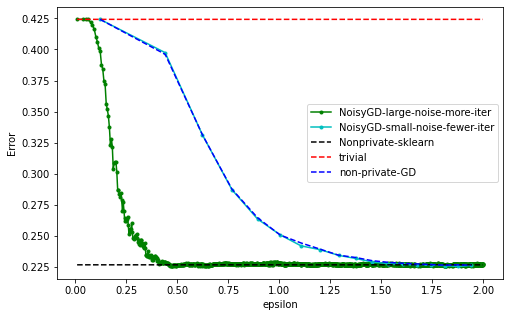

In [8]:
## Let's also plot the results
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
#plt.plot(eps_GD2, err_GD0,'b.-')
plt.plot(eps_GD1, err_GD1,'g.-')
plt.plot(eps_GD2, err_GD2,'c.-')
plt.plot(eps_GD1,err_nonprivate*np.ones_like(eps_GD1),'k--')
plt.plot(eps_GD1,err_trivial*np.ones_like(eps_GD1),'r--')
plt.plot(eps_GD2,err_GD0,'b--')
#plt.ylim([0,0.1])

plt.legend(['NoisyGD-large-noise-more-iter','NoisyGD-small-noise-fewer-iter','Nonprivate-sklearn','trivial','non-private-GD'])
plt.xlabel('epsilon')
plt.ylabel('Error')
plt.show()

## 3. What do you see in your experiments?

The larger noise more iter NoisyGD converge faster. when $\epsilon$ lager than 1.75, they are similar.

## 4. What if we wiggle the learning rate for a bit?

Next,  we will consider the stability of the learning rate choices by trying larger and smaller learning rate near the theoretical choice:

3. Multiplying the learning rate by 10
4. Dividing the learning rate by 10
5. Multiplying the learning rate by 100

In [9]:
sigma = 300.0
eps = 2.0
delta = 1e-6
niter = find_appropriate_niter(sigma, eps,delta)

lr = 10*theoretical_lr_choice(beta_L,f0_minus_fniter_bound,dim,sigma*GS,niter)
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)

err_GD3, eps_GD3 = run_NoisyGD(sigma,lr,niter,log_gap=100)

lr = 0.1*theoretical_lr_choice(beta_L,f0_minus_fniter_bound, dim,sigma*GS,niter)
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)

err_GD4, eps_GD4 = run_NoisyGD(sigma,lr,niter,log_gap=100)

lr = 100*theoretical_lr_choice(sigma,f0_minus_fniter_bound,dim,sigma*GS,niter)
# Theoretical choice for GD  (those this is giving GD a bit of unfair advantage because lambdamax is data-dependent)

err_GD5, eps_GD5 = run_NoisyGD(sigma,lr,niter,log_gap=100)



/tmp/ipykernel_10022/1769394043.py:47: RuntimeWarning: overflow encountered in exp
  GS = np.exp(np.linalg.norm(theta))/(1+np.exp(np.linalg.norm(theta)))
/tmp/ipykernel_10022/1769394043.py:47: RuntimeWarning: invalid value encountered in double_scalars
  GS = np.exp(np.linalg.norm(theta))/(1+np.exp(np.linalg.norm(theta)))


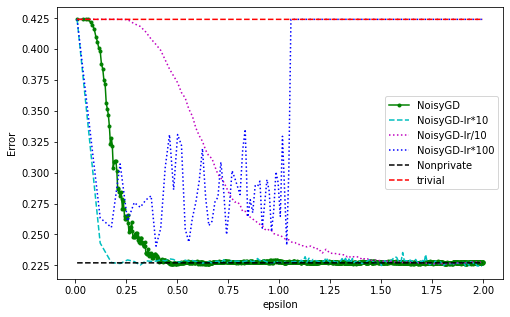

In [10]:
# Let's also plot the median
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
# plt.plot(eps_budget_list,med_MSE_list[:,0],'o-')
# plt.plot(eps_budget_list,med_MSE_list[:,1],'s-')
plt.plot(eps_GD1, err_GD1,'g.-')
plt.plot(eps_GD3, err_GD3,'c--')
plt.plot(eps_GD4, err_GD4,'m:')
plt.plot(eps_GD5, err_GD5,'b:')
plt.plot(eps_GD1,err_nonprivate*np.ones_like(eps_GD1),'k--')
plt.plot(eps_GD1,err_trivial*np.ones_like(eps_GD1),'r--')


plt.legend(['NoisyGD','NoisyGD-lr*10','NoisyGD-lr/10','NoisyGD-lr*100','Nonprivate','trivial'])
plt.xlabel('epsilon')
plt.ylabel('Error')
plt.show()

## 5. Write two paragraphs sto explain what you observed in your experiments. 

When we wiggle the learning rate*100, the error changed rapidly, so the Noisy GD is sensitive to the choice of learning rate. If we just set lr*10, it will converge faster.

Compared with the nonprivate algorithm, when $\epsilon$ increases, the noisy GD get closer to the nonprivate algorithm if lr is appropriate.

## 6. Bonus questsions for you to explore yourself:  

1. What happens if you use loss function instead of classification error?
2. What happens if you use return average parameter theta, rather than just the last iteration?

